## Importing modules

In [1]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy.parser import Biomart
import os
import numpy as np
import seaborn as sns
from gseapy.plot import gseaplot
from scipy import stats as st
import fnmatch

## Setting base directory

In [ ]:
# ! mkdir '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/TF_Enrichment'


In [2]:
Base_dir='/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/TF_Enrichment'
os.chdir(Base_dir)

## Reading input files: GeneSets(gmt), PathwayToGenes and Gene Correlations 

In [3]:
pathway_filename1 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_1.gmt';
pathway_filename2 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_2.gmt';
pathway_filename3 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_3.gmt';
pathway_filename4 = '/data/nandas/Combined_coexp/Pathway_enrichment/NewSets_090420/Genesets_NAME_090320_LEVEL_4.gmt';
TF_metabol_pairs=pd.read_csv("MetabolicPlusTFCorr.dat",header=None,sep='\t')

## Pathway enrichment analyses for individual TFs

In [4]:
def PreRank(gene, outdir,gene_sets):
    Combined=metabolic_corr_df[gene];
    Combined.dropna(inplace=True)
#     print(Mean)
    rnk=Combined.sort_values(ascending=False)
    #print("Rank: {}".format(rnk))    
    pre_res = gp.prerank(rnk=rnk, gene_sets=gene_sets, processes=4,min_size=3, outdir=outdir, format='png', 
                         weighted_score_type=1,verbose=True)
    return pre_res

def _is_regulated_pathway_(pre_res, gene):
#     print('Hello There: {}'.format(pre_res));
#     print('Shivani Here: {}'.format(pre_res.res2d))
    pathway_pre_res = pre_res.res2d.sort_values(by=['fdr'],ascending=True);
#     is_regulated_pathway = pathway_pre_res.es >= 0.70 and pathway_pre_res.fdr <= 0.05
#     print(pathway_pre_res.fdr[0])
    is_regulated_pathway = False; 
    print(is_regulated_pathway)
    for index in pathway_pre_res.index:
        val = pathway_pre_res.loc[index];
#         print(val)
        if(val.fdr <= 0.05 and val.nes > 0 and val.es >0 and val.nes!=np.inf):
            is_regulated_pathway = True;
#             print("Changed IsRegulatedValue to True");
#             print("FDR: {}---NES: {}---: ES:{}".format(val.fdr, val.nes, val.es))
            break;
    print("OutsideLoop: {}".format(is_regulated_pathway));
    return is_regulated_pathway;

def PlotEnrichment(pre_res,gene, outdir):
    Sorted_values=pre_res.res2d.sort_values(ascending=False,by=['nes'])[0:20]
    Sorted_values=Sorted_values[Sorted_values.fdr<=0.05]
    Sorted_values.to_csv("Pathways_enriched_{}.csv".format(gene))
    fig = plt.figure()
    df = pd.DataFrame({'Enrichment Score': Sorted_values.es,
                   'p-value': Sorted_values.pval,'FDR':Sorted_values.fdr}, index=Sorted_values.index)
    df2=pd.DataFrame({'NES':Sorted_values.nes,'FDR':Sorted_values.fdr},index=Sorted_values.index)
    ax = df.plot.barh(rot=0)
    ax.invert_yaxis()
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.savefig("{}/{}_plot.png".format(outdir, gene),bbox_inches = 'tight')
    plt.show()
    plt.close()
    ax2=df2.plot.barh(rot=0)
    ax2.invert_yaxis()
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.xlabel('Normalized enrichment score')
    plt.savefig("{}/{}_nes.png".format(outdir, gene),bbox_inches = 'tight')
    plt.show()
    
def PlotGSEA(pre_res, gene, outdir):
#     fig,ax=plt.subplots(ncols=2,nrows=2)
    terms = pre_res.res2d.sort_values(by=['fdr'],ascending=True)
    term_index=terms.index
#     print(terms[0:2])
    if terms.nes[0]>0:
        fig=gseaplot(rank_metric=pre_res.ranking, term=term_index[0], **pre_res.results[term_index[0]])
#     ax2=gseaplot(rank_metric=pre_res.ranking, term=term_index[0], **pre_res.results[term_index[1]])
#     ax3=gseaplot(rank_metric=pre_res.ranking, term=term_index[0], **pre_res.results[term_index[2]])
#     ax4=gseaplot(rank_metric=pre_res.ranking, term=term_index[0], **pre_res.results[term_index[3]])
    
    else:
        fig=gseaplot(rank_metric=pre_res.ranking, term=term_index[1], **pre_res.results[term_index[1]])
    plt.savefig('{}/{}_gsea.png'.format(outdir,gene))
    
def ConvertPairsToMatrix(bayesian_metabol_df):
    bayesian_metabol_df.set_axis(['Gene1','Gene2','weight'], axis=1,inplace=True)
    a = np.unique(bayesian_metabol_df['Gene1'])
    b = np.unique(bayesian_metabol_df['Gene2'])
    c = np.union1d(a,b);
    data = np.zeros((len(c), len(c)));
    output_df = pd.DataFrame(data, index=c, columns=c)
    for values in bayesian_metabol_df.values: 
        output_df[values[0]][values[1]] = values[2];
        output_df[values[1]][values[0]]=values[2];
    np.fill_diagonal(output_df.values,1)
    return output_df

def wb_to_gene(matrix):
    mapper_df=pd.read_csv("/data/nandas/MEFIT/predicted/mapper_final.csv", header='infer',index_col=0)
    wb_to_gene = {};
    for wb in mapper_df.index:
        wb_to_gene[wb] = str(mapper_df.loc[wb]['GeneID']);
    matrix=matrix.rename(index=wb_to_gene,columns=wb_to_gene)
    return matrix

In [5]:
Pathway_df1=pd.read_csv(pathway_filename1,index_col=0,sep='\t')
Pathway_df2=pd.read_csv(pathway_filename2,index_col=0,sep='\t')
Pathway_df3=pd.read_csv(pathway_filename3,index_col=0,sep='\t')
Pathway_df4=pd.read_csv(pathway_filename4,index_col=0,sep='\t')

In [6]:
Pathway_df4.drop(['CHITIN_BREAKDOWN','GUANYLATE_CYCLASE'],inplace=True)

In [7]:
TF_metabol_pairs.set_axis(['Gene1','Gene2','weight'], axis=1,inplace=True)

In [8]:
TF_metabol_pairs.weight=(TF_metabol_pairs.weight*2)-1

In [ ]:
# TF_metabol_pairs.weight.hist(bins=1000,grid=False)

In [ ]:
# metabolic_corr_df=ConvertPairsToMatrix(TF_metabol_pairs)

In [ ]:
# metabolic_corr_df=wb_to_gene(metabolic_corr_df)

## Convert TF_metabolic gene pairwise expression to coexpression matrix

In [ ]:
# metabolic_corr_df.to_csv("MetabolicCorr092220.csv")

In [9]:
metabolic_corr_df=pd.read_csv("MetabolicCorr092220.csv",index_col=0)

In [ ]:
# metabolic_corr_df.drop(columns=)

In [10]:
np.fill_diagonal(metabolic_corr_df.values,'NaN')

In [28]:
metabolic_corr_df.drop(columns=['gei-3.1'],inplace=True)

In [29]:
metabolic_corr_df=metabolic_corr_df[~metabolic_corr_df.index.duplicated(keep='first')]
metabolic_corr_df=metabolic_corr_df.transpose()
metabolic_corr_df=metabolic_corr_df[~metabolic_corr_df.index.duplicated(keep='first')]

In [30]:
metabolic_corr_df.to_csv("MetabolicCorr092220.csv")

In [31]:
metabolic_corr_df=pd.read_csv("MetabolicCorr092220.csv",index_col=0)

In [ ]:
# metabolic_corr_df=wb_to_gene(metabolic_corr_df)

In [ ]:
# np.fill_diagonal(metabolic_corr_df.values,np.nan)

## Reading TFs

In [36]:
TF=pd.read_csv("/data/nandas/Resolve_OR_genes/TF.csv",header=None,index_col=0)
TF.drop(index=['WBGene00021924'],inplace=True)
TF=wb_to_gene(TF)
TF.drop(index=['ech-6'],inplace=True)

In [37]:
TF=TF[~TF.index.duplicated(keep='first')]
metabolic_corr_df=metabolic_corr_df[~metabolic_corr_df.index.duplicated(keep='first')]
metabolic_corr_df=metabolic_corr_df.transpose()
metabolic_corr_df=metabolic_corr_df[~metabolic_corr_df.index.duplicated(keep='first')]

In [38]:
# Get the list of TFs whose coexpression values are present in the combined matrix
intersected_list = list(set(metabolic_corr_df.index).intersection(set(TF.index)))
print(len(intersected_list))

TF_final = TF.loc[intersected_list]
# TF_final = TF_final.drop_duplicates()
TF_final.reset_index(inplace=True)
# TF_final.drop_duplicates(inplace=True)
TF_final.set_index(0, inplace=True)
TF_final=TF_final[~TF_final.index.duplicated(keep='first')]

937


In [39]:
TF_final.to_csv("intersected_TF_list.csv")

In [40]:
# TF_final.transpose().to_csv("transposed_TF.csv",sep=',')
TF_final

""
0
nhr-11
ceh-100
eyg-1
ccch-5
rbr-2
...
zip-4
F10E7.11
dmd-8


In [ ]:
# # metabolic_corr_df.rename(columns={'gei-3.1':'gei-3'},inplace=True)
# metabolic_corr_df.drop_duplicates(keep='first',inplace=True)
# metabolic_corr_df.transpose().drop_duplicates(keep='first',inplace=True)

In [41]:
Genes=metabolic_corr_df.copy(deep=True)
Genes ['IsRegulated']=False
Genes=Genes['IsRegulated']
Genes=pd.DataFrame(Genes)

tfvalue: nhr-31
(3436, 3436)
936
(2500, 2500)


2020-12-14 13:59:09,825 Parsing data files for GSEA.............................
2020-12-14 13:59:10,030 0005 gene_sets have been filtered out when max_size=500 and min_size=3
2020-12-14 13:59:10,032 0081 gene_sets used for further statistical testing.....
2020-12-14 13:59:10,034 Start to run GSEA...Might take a while..................
2020-12-14 13:59:13,572 Start to generate gseapy reports, and produce figures...
2020-12-14 13:59:35,662 Congratulations. GSEApy runs successfully................



False
OutsideLoop: True
False
OutsideLoop: True
nhr-31 is regulated:True


<Figure size 432x288 with 0 Axes>

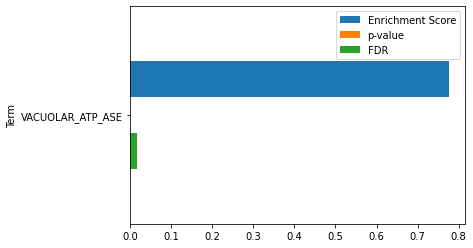

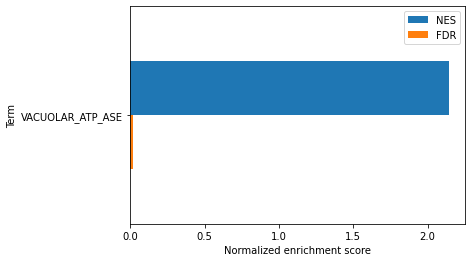

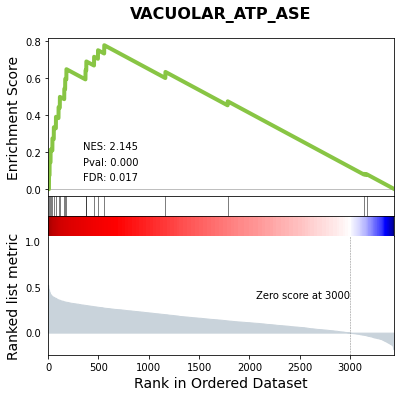

In [58]:
#Level_4
New_df=pd.DataFrame([])
for tf in TF_final.index:
    tf='nhr-31'
# for i in range(0,862):
#     tf = TF_final.index[i];
    print("tfvalue: {}".format(tf))
    print(metabolic_corr_df.shape)
    drop_list = TF_final.drop(index=tf)
    drop_list = drop_list.index
    print(len(drop_list))
    matrix = metabolic_corr_df.drop(index=drop_list, columns=drop_list);
    print(matrix.shape)
    file_exist = False;
    for file in os.listdir('./'):
        if fnmatch.fnmatch(file, "Pathways_enriched_{}.csv".format(tf)):
            print("File: {} found, skipping!!!".format(file))
            file_exist = True;
    if(not file_exist):
        pre_res = PreRank(tf, tf,gene_sets=pathway_filename4);
        if(pre_res is None):
            continue;
        else:
            Genes.at[tf, 'IsRegulated'] = _is_regulated_pathway_(pre_res, tf);
            print("{} is regulated:{}".format(tf,_is_regulated_pathway_(pre_res, tf)))
            PlotEnrichment(pre_res, gene=tf, outdir=tf)
            PlotGSEA(pre_res=pre_res,gene=tf,outdir=tf)
    break;
        
#Genes.to_csv("Genes_Regulation_status.csv")
#New_df.to_csv("Final_pathway_gsea.csv")

In [59]:
Pathways_nhr_68=pd.read_csv("Pathways_enriched_nhr-31.csv",index_col=0)

In [60]:
Pathways_nhr_68.sort_values(ascending=True,by =['fdr'])

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
VACUOLAR_ATP_ASE,0.776704,2.144953,0.0,0.017145,20,20,vha-5;vha-15;vha-12;vha-19;vha-11;vha-6;vha-2;...,vha-5;vha-15;vha-12;vha-19;vha-11;vha-6;vha-2;...


In [51]:
!rm Pathways_enriched_nhr-80.csv